In [1]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as sci

from marvin.tools.vacs import VACs
from astropy.io import fits
import numpy as np
from marvin.tools import Maps
from marvin.tools import Cube

from marvin import config #Needed to fix "Cube not subscriptable" when running in Sciserver
config.forceDbOff() #Needed to fix "Cube not subscriptable" when running in Sciserver

print('Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned')
#importing necessary functions

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned


In [2]:
#extracting the data

selection = 'all_data.fits'
hdu = fits.open(selection)
data = hdu[1].data

In [22]:
#a function to make plots for different properties

def subsampler(parameter):
    #selecting galaxies to remove
    non_usable=np.array([])

    for i in range(len(data)):
        if data[i]['mngtarg3']!=0:
            non_usable=np.append(non_usable,str(data[i]['plateifu_1']))
            
    #Calculate fractional mass error
    def massexcess(sigmass_ma, sigmass_mi, f):
        err_ma = sigmass_ma #std, and this is the error on log of value, hence the same as the fractional error on the value. 
        err_mi = sigmass_mi
        err_f = f*np.sqrt(err_ma**2 + 2*err_mi**2) # err_not is twice becauses it's in the denominator
        return err_f
    
    #Fractional mass errors for the sample
    plateifus=data['plateifu_1']
    sig_ma=data['sigmass_ma'].astype('float')
    sig_mi=data['sigmass_mi'].astype('float')
    fun=data['mass_excess'].astype('float')
    cnt_ma=data['count_ma'].astype('float')
    cnt_mi=data['count_mi'].astype('float')
    err_f=np.absolute(massexcess(sig_ma,sig_mi,fun))
    
    #Selecting galaxies to be used (parameter subsample)
    usable=np.array([])
    rad=np.array([])
    m_ma=np.array([])
    m_mi=np.array([])
    f=np.array([])
    sigmass_ma=np.array([])
    sigmass_mi=np.array([])
    count_ma=np.array([])
    count_mi=np.array([])
    par=np.array([])
    likely_bar=np.array([])
    for i in range(len(plateifus)):
        if plateifus[i] not in non_usable and err_f[i]!=np.nan and err_f[i]<0.5 and cnt_ma[i]>10 and cnt_mi[i]>10:
            usable=np.append(usable,data[i]['plateifu_1'])
            rad=np.append(rad,float(data[i]['radius']))
            m_ma=np.append(m_ma,float(data[i]['arm_mass']))
            m_mi=np.append(m_mi,float(data[i]['interarm_mass']))
            f=np.append(f,float(data[i]['mass_excess']))
            sigmass_ma=np.append(sigmass_ma,float(data[i]['sigmass_ma']))
            sigmass_mi=np.append(sigmass_mi,float(data[i]['sigmass_mi']))
            count_ma=np.append(count_ma,float(data[i]['count_ma']))
            count_mi=np.append(count_mi,float(data[i]['count_mi']))
            par=np.append(par,data[i][parameter])
            likely_bar=np.append(likely_bar,data[i]['GZ_BAR_VOTES']/data[i]['GZ_TOTAL_CLASSIFICATIONS'])
                
    return usable,rad,m_ma,m_mi,f,sigmass_ma,sigmass_mi,count_ma,count_mi,par,likely_bar

In [23]:
#running the function for a parameter
usable,rad,m_ma,m_mi,f,sigmass_ma,sigmass_mi,count_ma,count_mi,par,likely_bar=subsampler('GZ_bar_votes')

In [37]:
#Getting values to plot
excess_mean,par_mean,binnumber = sci.binned_statistic(likely_bar,f,bins=25)
excess_err,par_mean,binnumber = sci.binned_statistic(likely_bar,f,bins=25,statistic='std')
excess_count,par_mean,binnumber = sci.binned_statistic(likely_bar,f,bins=25,statistic='count')
delta = (likely_bar[1]-likely_bar[0])/2.0 #to put plot points in middle of bin

(-0.1, 0.6)

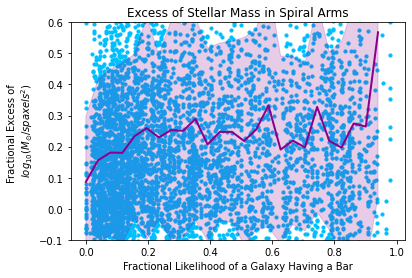

In [38]:
#general parameter plot code
plt.scatter(likely_bar,f,s=10,c='deepskyblue')
plt.plot(par_mean[:-1]+delta, excess_mean,c='darkmagenta',linewidth=2)
plt.fill_between(par_mean[:-1]+delta, excess_mean-excess_err,excess_mean+excess_err,alpha=0.2,color='darkmagenta')
plt.xlabel('Fractional Likelihood of a Galaxy Having a Bar')
plt.ylabel('Fractional Excess of \n $log_{10}(M_{\odot}/spaxels^2)$')
plt.title('Excess of Stellar Mass in Spiral Arms')
plt.ylim(-0.1,0.6)

In [39]:
#separating the parameter into cathegories
smass=np.array([])
sbmass=np.array([])
rad_s=np.array([])
rad_sb=np.array([])
for i in range(len(likely_bar)):
    if likely_bar[i]<0.3:
        smass=np.append(smass,f[i])
        rad_s=np.append(rad_s,rad[i])
    elif likely_bar[i]>0.3:
        sbmass=np.append(sbmass,f[i])
        rad_sb=np.append(rad_sb,rad[i])

In [46]:
#different cathegories binning
s_mean,srad_mean,binnumber = sci.binned_statistic(rad_s,smass,bins=25,range=[0,3])
s_err,srad_mean,binnumber = sci.binned_statistic(rad_s,smass,bins=25,statistic='std',range=[0,3])
s_count,srad_mean,binnumber = sci.binned_statistic(rad_s,smass,bins=25,statistic='count',range=[0,3])
delta = (rad_s[1]-rad_s[0])/2.0 #to put plot points in middle of bin
sb_mean,sbrad_mean,binnumber = sci.binned_statistic(rad_sb,sbmass,bins=25,range=[0,3])
sb_err,sbrad_mean,binnumber = sci.binned_statistic(rad_sb,sbmass,bins=25,statistic='std',range=[0,3])
sb_count,sbrad_mean,binnumber = sci.binned_statistic(rad_sb,sbmass,bins=25,statistic='count',range=[0,3])

In [49]:
#removing bins with few data points
s_masses=np.array([])
sb_masses=np.array([])
s_radius=np.array([])
sb_radius=np.array([])
for i in range(len(s_count)):
    if s_count[i]>10 and s_mean[i]!=np.nan:
        s_masses=np.append(s_masses,s_mean[i])
        s_radius=np.append(s_radius,srad_mean[i])
for i in range(len(sb_count)):
    if sb_count[i]>10 and sb_mean[i]!=np.nan:
        sb_masses=np.append(sb_masses,sb_mean[i])
        sb_radius=np.append(sb_radius,sbrad_mean[i])

(-0.1, 0.6)

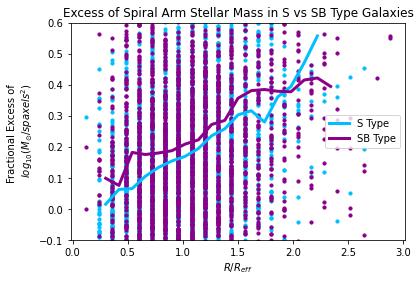

In [52]:
#different cathegories plot code
plt.scatter(rad_s,smass,s=10,c='deepskyblue')
plt.scatter(rad_sb,sbmass,s=10,c='darkmagenta')
#plt.fill_between(sbrad_mean[:-1]+delta, sb_mean-sb_err,sb_mean+sb_err,alpha=0.2,color='darkmagenta')
#plt.fill_between(srad_mean[:-1]+delta, s_mean-s_err,s_mean+s_err,alpha=0.2,color='deepskyblue')
plt.plot(s_radius+delta, s_masses,c='deepskyblue',linewidth=3,label='S Type')
plt.plot(sb_radius+delta, sb_masses,c='darkmagenta',linewidth=3,label='SB Type')
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Fractional Excess of \n $log_{10}(M_{\odot}/spaxels^2)$')
plt.title('Excess of Spiral Arm Stellar Mass in S vs SB Type Galaxies')
plt.legend()
plt.ylim(-0.1,0.6)